In [1]:
from bayesian_regression.util.generators import random_poisson_model
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import pandas as pd
from biom import load_table

import edward as ed
import tensorflow as tf
%matplotlib inline

/Users/mortonjt/miniconda3/envs/bayesian-regression/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/mortonjt/miniconda3/envs/bayesian-regression/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Simulation

We will first propose a generative model model species distributions.

The model will be constructed as follows

Generate a linear regression given known regression coefficients and intercepts (B) and known environmental gradients (G)

$v = GB$

$v$ represents the log ratios (also known as logits) of the species.  These logits can ultimately be used to interpret trends of ecological succession amongst groups of species.  However, these log ratios cannot be directly estimated (since it isn't possible to take the logarithm of zero).  Instead, we will rely on the generative process, and convert these log ratios to proportions, before generating counts.

$v$ can be converted to proportions using the ILR transform.  $v$ has $D-1$ dimensions, where $D$ is the number of species.  The ILR transform can be represented as follows

$\eta = \Psi v$

where $\Psi$ is an orthonormal basis of dimensions $D \times D-1$.  It is possible to encode a tree topology into $\Psi$.  One approach is to take phylogenetic trees in order to infer evolutionary trends with respect to environmental gradients.  For the sake of simplicity, we will choose an arbituary tree.  In terms of generating microbial counts, the choice tree doesn't matter since all trees will generate orthonormal bases that are equivalent up to rotation.

Once we have proportions estimated by $\eta$, we can then use these proportions to parameterize a counting distribution, such as the Multinomial distribution, the Poisson distribution or the Negative Binomial distribution.

Here we will use the Poisson distribution to simulate microbial counts.  In order to account or differences due to sequencing depth and additional sample biases, a bias constant $\theta$ is added to the model.  A global bias $\alpha$ is added to everything.

$Y \sim Poisson( exp(\eta + \theta + \alpha) )$

To evaluate how well the model fits, we will first simulate the data given the model.  We will randomly simulate the coefficients from a given prior distribution, and then generate the counts from the model.
If the model works, we should be able to recover the underlying parameters, and regenerate the microbial count table.

In [ ]:
def softplus(x):
    return np.log(1 + np.exp(x))

def random_poisson_model(num_samples, num_features,
                         tree=None,
                         low=2, high=10,
                         alpha_mean=0,
                         alpha_scale=5,
                         theta_mean=0,
                         theta_scale=5,
                         gamma_mean=0,
                         gamma_scale=5,
                         kappa_mean=0,
                         kappa_scale=5,
                         beta_mean=0,
                         beta_scale=5,
                         seed=0):
    """ Generates a table using a random poisson regression model.

    Here we will be simulating microbial counts given the model, and the
    corresponding model priors.

    Parameters
    ----------
    num_samples : int
        Number of samples
    num_features : int
        Number of features
    basis : np.array
        Orthonormal contrast matrix.
    low : float
        Smallest gradient value.
    high : float
        Largest gradient value.
    alpha_mean : float
        Mean of alpha prior  (for global bias)
    alpha_scale: float
        Scale of alpha prior  (for global bias)
    theta_mean : float
        Mean of theta prior (for sample bias)
    theta_scale=5
        Scale of theta prior (for sample bias)
    gamma_mean : float
        Mean of gamma prior (for feature bias)
    gamma_scale=5
        Scale of gamma prior (for feature bias)
    kappa_mean : float
        Mean of kappa prior (for overdispersion)
    kappa_scale=5
        Scale of kappa prior (for overdispersion)
    beta_mean : float
        Mean of beta prior (for regression coefficients)
    beta_scale=5
        Scale of beta prior (for regression coefficients)

    Returns
    -------
    table : biom.Table
        Biom representation of the count table.
    metadata : pd.DataFrame
        DataFrame containing relevant metadata.
    beta : np.array
        Regression parameter estimates.
    theta : np.array
        Bias per sample.
    gamma : np.array
        Bias per feature
    kappa : np.array
        Dispersion rates of counts per sample.
    """
    # generate all of the coefficient using the random poisson model
    state = check_random_state(seed)
    alpha = state.normal(alpha_mean, alpha_scale)
    theta = state.normal(theta_mean, theta_scale, size=(num_samples, 1))
    beta = state.normal(beta_mean, beta_scale, size=num_features-1)
    gamma = state.normal(gamma_mean, gamma_scale, size=num_features-1)
    kappa = state.normal(kappa_mean, kappa_scale, size=num_features)

    if tree is None:
        basis = coo_matrix(_gram_schmidt_basis(num_features), dtype=np.float32)
    else:
        basis = sparse_balance_basis(tree)[0]

    G = np.linspace(low, high, num_samples)
    N, D = num_samples, num_features
    G_data = np.vstack((np.ones(N), G)).T
    B = np.vstack((gamma, beta))
    V = G_data @ B @ basis + theta + alpha
    #kprime = kappa @ basis
    
    # we use kappa here to handle overdispersion.
    mu = np.vstack((state.normal(V[:, i] + alpha, softplus(kappa[i]))
                    for i in range(num_features))).T
    table = np.vstack(
        state.poisson(np.exp(mu[i, :]))
        for i in range(mu.shape[0])
    ).T

    samp_ids = ['S%d' % i for i in range(num_samples)]
    feat_ids = ['F%d' % i for i in range(num_features)]
    balance_ids = ['L%d' % i for i in range(num_features-1)]

    table = Table(table, feat_ids, samp_ids)
    metadata = pd.DataFrame({'G': G.ravel()}, index=samp_ids)
    beta = pd.DataFrame({'beta': beta.ravel()}, index=balance_ids)
    gamma = pd.DataFrame({'gamma': gamma.ravel()}, index=balance_ids)
    kappa = pd.DataFrame({'kappa': kappa.ravel()}, index=feat_ids)
    theta = pd.DataFrame({'theta': theta.ravel()}, index=samp_ids)
    return table, metadata, basis, alpha, beta, theta, gamma, kappa

In [2]:
num_samples = 1000
num_features = 200
res = random_poisson_model(num_samples, num_features,
                           low=-1, high=1,
                           alpha_mean=-2,
                           alpha_scale=1,
                           theta_mean=0,
                           theta_scale=1,
                           gamma_mean=0,
                           gamma_scale=1,
                           kappa_mean=0,
                           kappa_scale=0.5,
                           beta_mean=0,
                           beta_scale=1
                          )
table, metadata, basis, sim_alpha, sim_beta, sim_theta, sim_gamma, sim_kappa = res

Text(0.5,1,'Simulation')

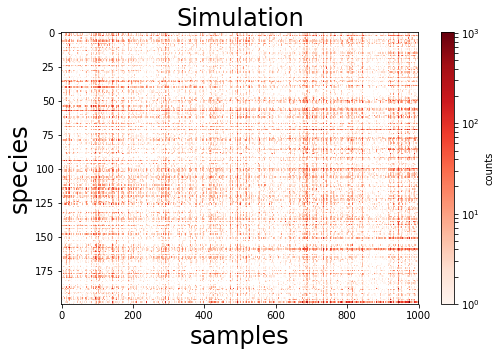

In [3]:
# Plot the heatmap of the counts
fig = plt.figure(figsize=(8, 5))
plt.imshow(table.matrix_data.todense(), 
           aspect='auto', cmap='Reds', 
           norm=colors.LogNorm()
          )
plt.colorbar(label='counts')
plt.ylabel('species', fontsize=24)
plt.xlabel('samples', fontsize=24)
plt.title('Simulation', fontsize=24) 

In [4]:
table

200 x 1000 <class 'biom.table.Table'> with 99153 nonzero entries (49% dense)

In [5]:
from bayesian_regression.util.balances import sparse_balance_basis

# Priors
alpha_mean = -2
alpha_scale = 1
theta_mean = 0
theta_scale = 1
gamma_mean = 0
gamma_scale = 1
kappa_mean = 0
kappa_scale = 0.5
beta_mean = 0
beta_scale = 1

# Mini batch size
batch_size = 5000 
basis = basis.T
config = tf.ConfigProto(intra_op_parallelism_threads=2, 
                        inter_op_parallelism_threads=2,
                        device_count={'CPU': 4}) 
sess = tf.InteractiveSession(config=config)

# Model

This is where we will specify the model.  Specifically

$v_{ij} = \alpha + \theta_i + \gamma_j + g_{i.} \cdot \beta_{.j}$

$\eta_i = \Psi v_i$

$Y_i \sim Poisson( \exp(\eta_i) )$

$\gamma$ represents the intercept terms and $\beta$ represent the regression coefficient terms.

G and Y are both observed.  Since we are estimating both $B$ and $\theta$, we will need set priors for both of these variables.  We will set unit normal priors on both of these variables

In [6]:
from bayesian_regression.util.model import sparse_matmul
from bayesian_regression.util.balances import ilr_to_clr
from edward.models import Normal, Poisson

N, D = num_samples, num_features
p = metadata.shape[1]   # number of covariates
G_data = metadata.values
# dummy variables for mini-batch size
batch_row = tf.placeholder(tf.int32, shape=[batch_size], name='batch_i')
batch_col = tf.placeholder(tf.int32, shape=[batch_size], name='batch_j')

# global bias
alpha = Normal(loc=tf.zeros([]) + alpha_mean,
               scale=tf.ones([]) * alpha_scale,
               name='alpha')

# sample bias
theta = Normal(loc=tf.zeros([N]) + theta_mean,
               scale=tf.ones([N]) * theta_scale,
               name='theta')
# species bias
gamma = Normal(loc=tf.zeros([1, D-1]) + gamma_mean,
               scale=tf.ones([1, D-1]) * gamma_scale, 
               name='gamma')

kappa = Normal(loc=tf.zeros([D, 1]) + kappa_mean,
               scale=tf.ones([D, 1]) * kappa_scale, 
               name='kappa')

# dummy variable for gradient                                                                 
G = tf.placeholder(tf.float32, [N, p], name='G')

# add bias terms for samples
Gprime = tf.concat([tf.ones([N, 1]), G], axis=1)

# Specify regression coefficents
B = Normal(loc=tf.zeros([p, D-1]) + beta_mean,
           scale=tf.ones([p, D-1]) * beta_scale, 
           name='B')

# add bias terms for features
Bprime = tf.concat([gamma, B], axis=0)

# Convert basis to SparseTensor
psi = tf.SparseTensor(
    indices=np.mat([basis.row, basis.col]).transpose(),
    values=basis.data,
    dense_shape=basis.shape)

# clr transform coefficients first                                                             
V = ilr_to_clr(Bprime, psi)

# retrieve entries selected by index
eta = sparse_matmul(
    Gprime, V, 
    row_index=batch_row, col_index=batch_col
)

phi = Normal(loc=eta + tf.gather(theta, batch_row) + alpha, 
             scale=tf.nn.softplus(tf.squeeze(tf.gather(kappa, batch_col, axis=0))))

# obtain counts                                          
Y = Poisson(rate=tf.exp(phi), name='Y') 

In [7]:
from edward.models import PointMass

# Learning parameters
learning_rate = 1e-1
beta1 = 0.9
beta2 = 0.99
iterations = 2000

# initialize the summaries
summary_dir = 'summary-dir'

In [8]:
GATE_OP=1
class ClippedAdamOptimizer(tf.train.AdamOptimizer):
    """
    Clipped version adam optimizer, where its gradient is clipped by value
    so that it cannot be too large.
    """
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999,
                 epsilon=1e-08, use_locking=False,
                 clip_func=lambda x: tf.clip_by_value(x, 1.0e-4, 1.0e4),
                 name='Adam'):
        super(ClippedAdamOptimizer, self).__init__(
            learning_rate, beta1, beta2, epsilon, use_locking, name)
        self._clip_func = clip_func

    def compute_gradients(self, loss, var_list=None, gate_gradients=GATE_OP,
                          aggregation_method=None,
                          colocate_gradients_with_ops=False, grad_loss=None):
        grad_and_vars = super(ClippedAdamOptimizer, self).compute_gradients(
            loss, var_list, gate_gradients, aggregation_method,
            colocate_gradients_with_ops, grad_loss)
        # clip func
        if self._clip_func is None:
            return grad_and_vars
        return [(self._clip_func(g, v) if g is not None else (g, v)
                for g, v in grad_and_vars)]

We will build the model using mini-batch stochastic gradient descent.  This done for two reasons : (1) to ensure faster convergence and (2) to take advantage of the inherient sparsity in microbiome datasets.

Microbiome datasets are very sparse, analogous to word counts in a document.  There may be as few as 1% of the entries in the matrix are nonzero.  To represent the matrix in a sparse format, we will us a COO-format.  The observed matrix will be represented as (i, j, data_ij) coordinates, where i represent row index, j represents column index, and data_ij represents the data value in the (i, j) index.  This will ultimately allow us to focus on performing inference on the non-zero values.

As a part of the mini-batch gradient descent, we will do bootstrapping technique.  In our case we will select 1000 entries.  Of those 1000 entries, half of those entries will correspond to non-zero values, and the remaining half correspond to zeros in the matrix.  This is to balance the parameter estimation, so that we don't bias the parameter estimates only to the nonzero values.  This is a commonly used technique in recommender systems when one can only rely on positive observed values.

In [9]:
# These are the posterior distributions.
tf.set_random_seed(0)

qalpha = PointMass(
    params=tf.Variable(tf.random_normal([])),
    name='qalpha')

qkappa = PointMass(
    params=tf.Variable(tf.random_normal([D, 1])) ,
    name='qkappa')

qgamma = PointMass(
    params=tf.Variable(tf.random_normal([1, D-1])) ,
    name='qgamma')

qtheta = PointMass(
    params=tf.Variable(tf.random_normal([N])),
    name='qtheta')

qB = PointMass(
    params=tf.Variable(tf.random_normal([p, D-1])) ,
    name='qB')


# a placeholder for the microbial counts
# since we will be manually feeding it into the inference via minibatch SGD
Y_ph = tf.placeholder(tf.float32, shape=[batch_size], name='Y_placeholder')

inference = ed.MAP({
    theta: qtheta,
    alpha: qalpha,
    gamma: qgamma,
    kappa: qkappa,
    B: qB},
    data={G: G_data, Y: Y_ph}
)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                   beta1=beta1,    
                                   beta2=beta2)
# adds checks for nans
tf.add_check_numerics_ops()

#sess = ed.get_session()

saver = tf.train.Saver()
inference.initialize(n_iter=iterations,
                     optimizer=optimizer,
                     n_print=100,
                     log_vars=[
                         qB,
                         qgamma,
                         qtheta,
                         qalpha,
                         qkappa
                     ],
                     logdir=summary_dir)

# initialize all tensorflow variables
init_op = tf.global_variables_initializer()
sess.run(init_op)
#tf.global_variables_initializer().run()

In [10]:
# if we really want to take advantage of tensorflow parallelism
# its best to make sure that the objects stay in tensorflow memory longer
# so we will loop over the same minibatch `rep` times.
reps = 100  
losses = np.array([0.] * (inference.n_iter // reps))
errors = np.array([0.] * (inference.n_iter // reps))

data = table.matrix_data.tocoo().T
md = np.hstack((np.ones((N, 1)), G_data))

y_row, y_col, y_data = data.row, data.col, data.data

In [11]:
from bayesian_regression.util.inference import get_batch

best_loss = np.inf
best_beta = sess.run(qB.mean())
best_theta = sess.run(qtheta.mean())
best_gamma = sess.run(qgamma.mean())
best_kappa = sess.run(qkappa.mean())
best_alpha = sess.run(qalpha.mean())

for i in range(inference.n_iter // reps):        
    # get batches
    idx_row, idx_col, idx_data = get_batch(M=batch_size, Y=data, p=0.5)
    for _ in range(reps):
        info_dict = inference.update(
            feed_dict={batch_row: idx_row, batch_col: idx_col, Y_ph: idx_data})
        losses[i] = info_dict['loss']
    inference.print_progress(info_dict)
        
    if (not np.any(np.isnan(sess.run(qB.mean()))) and 
        not np.any(np.isnan(sess.run(qtheta.mean()))) and
        not np.any(np.isnan(sess.run(qgamma.mean()))) and
        not np.isnan(sess.run(qalpha.mean()))
       ):
        beta_ = sess.run(qB.mean())
        theta_ = sess.run(qtheta.mean())
        gamma_ = sess.run(qgamma.mean())
        alpha_ = sess.run(qalpha.mean())
        
        bprime = np.vstack((gamma_, beta_))
        log_u = ((md @ bprime @ basis.T).T + theta_).T + alpha_
        err = np.mean((np.exp(log_u[y_row, y_col]) - y_data).ravel() ** 2)
        errors[i] = err

        if losses[i] < best_loss:
            # always remember the best result.
            best_loss = losses[i]
            best_beta = sess.run(qB.mean())
            best_theta = sess.run(qtheta.mean())
            best_gamma = sess.run(qgamma.mean())
            best_alpha = sess.run(qalpha.mean())

2000/2000 [100%] ██████████████████████████████ Elapsed: 11s | Loss: 9620.199


In [12]:
losses[-1], errors[-1]

(9620.19921875, 279.6260078760378)

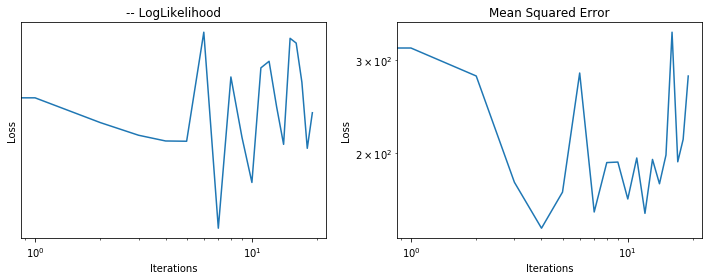

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(losses)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Iterations')
ax[0].set_title('-- LogLikelihood')

ax[1].plot(errors)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Iterations')
ax[1].set_title('Mean Squared Error')
plt.tight_layout()

Text(0,0.5,'Features')

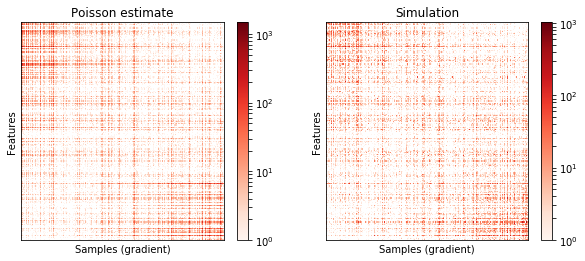

In [14]:
import matplotlib.colors as colors
from gneiss.sort import niche_sort
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
bprime = np.vstack((gamma_, beta_))
log_u = ((md @ bprime @ basis.T).T + theta_).T + alpha_

etable = np.zeros((N, D))
for i in range(etable.shape[0]): 
    etable[i] = np.random.poisson(np.exp(log_u[i]))

rtable = pd.DataFrame(table.matrix_data.todense().T,
                      index=table.ids('sample'),
                      columns=table.ids('observation'))
rtable = niche_sort(rtable, metadata.G)
etable = pd.DataFrame(etable, index=table.ids('sample'),
                      columns=table.ids('observation'))
etable = etable.reindex(index=rtable.index, columns=rtable.columns)

img1 = ax[0].imshow(etable.T, aspect='auto', cmap='Reds', norm=colors.LogNorm())
fig.colorbar(img1, ax=ax[0])
#sns.heatmap(etable.T, robust=True, ax=ax[0], cmap="Reds")
ax[0].set_title('Poisson estimate')
ax[0].set_xticks([])
ax[0].set_xlabel('Samples (gradient)')
ax[0].set_yticks([])
ax[0].set_ylabel('Features')

img2 = ax[1].imshow(rtable.T, 
                    aspect='auto', cmap='Reds', norm=colors.LogNorm())
fig.colorbar(img2, ax=ax[1]) 

#sns.heatmap(rtable.T, robust=True, ax=ax[1], cmap="Reds")
ax[1].set_title('Simulation')
ax[1].set_xticks([])
ax[1].set_xlabel('Samples (gradient)')
ax[1].set_yticks([])
ax[1].set_ylabel('Features')

#fig.savefig('../results/heatmap_fit.pdf')

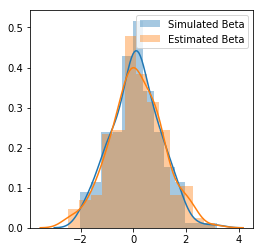

In [15]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(4, 4))
sns.distplot(sim_beta, ax=ax, label='Simulated Beta')
sns.distplot(beta_, ax=ax, label='Estimated Beta')
plt.legend()

(0.8118303865460806, 6.475471125919598e-48)


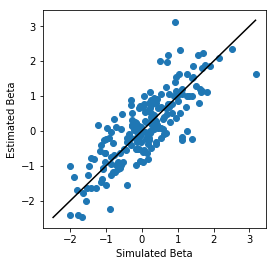

In [16]:
from scipy.stats import pearsonr
fig, ax = plt.subplots(figsize=(4, 4))
x = np.ravel(sim_beta)
y = np.ravel(beta_)
ax.scatter(x, y)
mx = np.linspace(min([sim_beta.values.min(), beta_.min()]), 
                 max([sim_beta.values.max(), beta_.max()]))
ax.plot(mx, mx, '-k')
plt.xlabel('Simulated Beta')
plt.ylabel('Estimated Beta')
print(pearsonr(x, y))

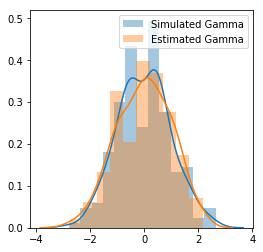

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.distplot(sim_gamma, ax=ax, label='Simulated Gamma')
sns.distplot(gamma_ , ax=ax, label='Estimated Gamma')
plt.legend()

(0.9077176876909333, 3.094201059982302e-76)


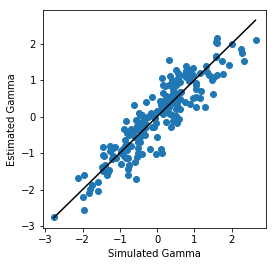

In [18]:
fig, ax = plt.subplots(figsize=(4, 4))
x = np.ravel(sim_gamma)
y = np.ravel(gamma_)
ax.scatter(x, y)
mx = np.linspace(min([sim_gamma.values.min(), gamma_.min()]), 
                 max([sim_gamma.values.max(), gamma_.max()]))
ax.plot(mx, mx, '-k')
plt.xlabel('Simulated Gamma')
plt.ylabel('Estimated Gamma')
print(pearsonr(x, y))

(0.7811458184255721, 2.2159749830374178e-206)


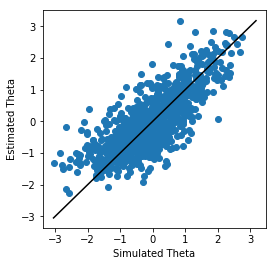

In [19]:
fig, ax = plt.subplots(figsize=(4, 4))
theta_ = best_theta
x, y = sim_theta.values.ravel(), theta_.ravel()
mx = np.linspace(min([x.min(), y.min()]), 
                 max([x.max(), y.max()]))

ax.scatter(x, y)
ax.plot(mx, mx, '-k')
ax.set_xlabel('Simulated Theta')
ax.set_ylabel('Estimated Theta')
print(pearsonr(x, y))

(0.028312170466158165, 0.6906562368093487)


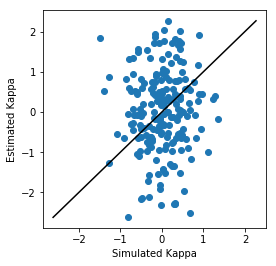

In [20]:
fig, ax = plt.subplots(figsize=(4, 4))
kappa_ = best_kappa
x, y = sim_kappa.values.ravel(), kappa_.ravel()
mx = np.linspace(min([x.min(), y.min()]), 
                 max([x.max(), y.max()]))

ax.scatter(x, y)
ax.plot(mx, mx, '-k')
ax.set_xlabel('Simulated Kappa')
ax.set_ylabel('Estimated Kappa')
print(pearsonr(x, y))